In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
        
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2012-02-28'
end_date = '2012-03-05'

dates = calc_temps(start_date, end_date)
temps_df = pd.DataFrame(dates, columns =('tmin','tavg','tmax'))
temps_df.head()

,tmin,tavg,tmax
0,62.0,69.571429,74.0


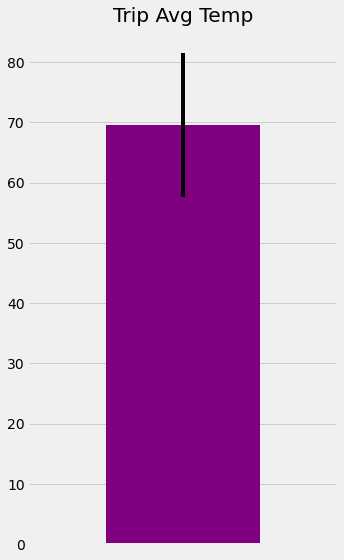

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,8))
ax = temps_df['tavg'].plot.bar(yerr = (temps_df['tmax'] - temps_df['tmin']), color='purple', title='Trip Avg Temp')
ax.axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.show()


### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, 
       func.sum(Measurement.prcp), 
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation
      ]
total_rainfall = session.query(*sel).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

total_rainfall

[('USC00519281', 11.08, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 10.32, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00513117', 5.79, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00518838', 3.8400000000000003, 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 2.92, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519397', 1.1800000000000002, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 0.76, 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00514830', 0.03, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2012-02-28'
end_date = '2012-03-05'

# Use the start and end date to create a range of dates
from_start = dt.datetime.strptime(start_date,'%Y-%m-%d')
from_end = dt.datetime.strptime(end_date,'%Y-%m-%d')
trip_length = from_end - from_start

# Strip off the year and save a list of strings in the format %m-%d
normal_dates = []
for i in range(trip_length.days + 1):
    current_day = from_start + dt.timedelta(days=i)
    month_day = dt.datetime.strftime(current_day,'%m-%d')
    normal_dates.append(month_day)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in normal_dates:
    normals.append(daily_normals(day)[0])

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['Minimum Temperature',
                                            'Average Temperature',
                                            'Maximum Temperature'], 
                          index=[normal_dates])
normals_df.index = normals_df.index.get_level_values(0)
normals_df.head()

,Minimum Temperature,Average Temperature,Maximum Temperature
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0


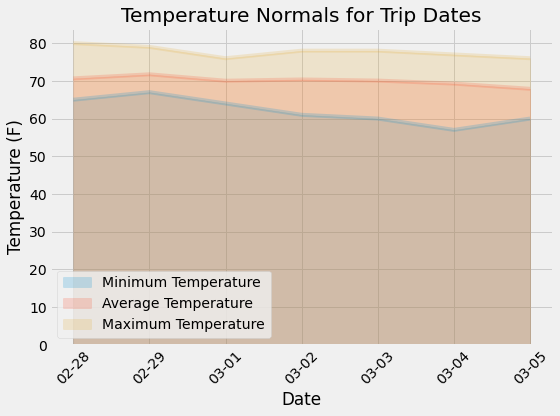

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot(kind='area', stacked=False, alpha=.2, rot=45, 
                     title = "Temperature Normals for Trip Dates", xlabel='Date', 
                     ylabel = "Temperature (F)", figsize =(8,6))
plt.tight_layout()
plt.show()

## Close Session

In [17]:
session.close()